# Executive Hour & Energy price forecasting

This notebook contains a selection of the models that were generated during the course of our work on energy price forecasting. The notebook will initialize each model, train it and then score it according to the validation and test data sets. Finally, all models are compared againts the chosen baseline model.
The target of our project is to predict the day-ahead price (`DA_price`) of electricty in New York city area. The DA price is the price of electricty that is charged at time `t` for delivery of electricty at time `t+24` hours. In contrast to the real-time (`RT`) price, which is for buying and selling electricty on the spot for immediate consumption and is therefore quite volatile, the `DA` price mechanism allows for an element of predictability and stability. 

In our case, we choose a reasonable baseline model: `DA_price` at time `t` is the same as the `DA_price` at time `t-24h`. This generates a baseline model that is surprisingly difficult to beat.

### Group Members:
Irem Altiner, Souparna Purohit, Nicolas Fortier, Rouzbeh Yazdi  
Mentor: Julian Rosen

In [1]:
## imports:
## our own models
import rouz_helpers as rhelp
import rouz_model as rmodel ## Rouz's model(s) --> multi-layered Deep NN and a ResNet
import LSTM as nmodel ## Nic's model(s) --> multi-layered LSTM
import irem_model as imodel ## Irem's model --> ARIMA
import XGB as smodel ## Souparna's model --> XGBoost regressor model

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, NullLocator
from datetime import datetime

from tensorflow import keras
import tensorflow as tf

In [3]:
## I am running on an M1 Mac machine and for some reason
## running tensorflow with GPU is a __pain__
tf.config.set_visible_devices([], "GPU")

## Baseline Model, Deep Neural Networks, Residual Networks

In [4]:
validation_scores = {}
test_scores = {}

In [5]:
## Read in the data, remove the first few days
train_df, val_df, test_df = rhelp.read_data_Nic()
train_df['time'] = pd.to_datetime(train_df['time'])
train_df = train_df[train_df.time > datetime(2020,11, 3, 23, 0, 0)]

for df in [train_df, val_df, test_df]:
    _ = df.pop('time')
    
mean = train_df.DA_price.mean()
std = train_df.DA_price.std()

mean_train = train_df.mean(numeric_only=True, axis=0)
std_train = train_df.std(numeric_only=True, axis=0)

train_df = (train_df - mean_train) / std_train
val_df   = (val_df   - mean_train) / std_train
test_df  = (test_df  - mean_train) / std_train

column_indices = {col: train_df.columns.get_loc(col) for col in train_df.columns}

In [6]:
## create windows of time to be fed into the models
SHIFT = 24
BATCH_SIZE = 128
## window no. 1: a narrow window of time, one hour of data, one hour prediction
narrow_window = rhelp.WindowGenerator(
        input_width=1,
        label_width=1,
        shift=1,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=["DA_price"],
        batch_size=BATCH_SIZE,
    )
## window no. 2: wide window, passes 24 hours of data for prediction
wide_window = rhelp.WindowGenerator(
        input_width=24,
        label_width=24,
        shift=SHIFT,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=["DA_price"],
        batch_size=BATCH_SIZE,
    )

In [7]:
PATIENCE, MAX_EPOCH = 10, 100

In [8]:
## Baseline model:
baseline_model = rmodel.Baseline(label_index=column_indices["DA_price"])
baseline_model.compile(loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])
validation_scores['Baseline'] = rmodel.get_rmse(baseline_model, wide_window.val, mean, std)
test_scores['Baseline']       = rmodel.get_rmse(baseline_model, wide_window.test, mean, std)

We can now plot the baseline model to take a look. The figures below show the Baseline model against three 24 hour window of data (no specific day or date). (Uncomment the code if you're interested!)

In [9]:
# _ = wide_window.plot(baseline_model, colors=['blue','green','orange'], max_subplots=3, title='Baseline')

In [10]:
## Linear Model:
%timeit
linear_model = rmodel.Linear(units=1)
linear_model_history = rmodel.compile_and_fit(linear_model, 
                                              window=wide_window, 
                                              patience=PATIENCE, 
                                              max_epochs=MAX_EPOCH)
validation_scores['Linear Model'] = rmodel.get_rmse(linear_model, wide_window.val, mean, std)
test_scores['Linear Model']       = rmodel.get_rmse(linear_model, wide_window.test, mean, std)

Now let's see the result of the predictions of the linear model. (Again, uncomment if you're interested!)

In [11]:
# _ = wide_window.plot(linear_model, colors=['blue','green','orange'], max_subplots=3, title='Linear model')

In [12]:
## Deep Neural Network model:
layers = 3
units = [64, 32, 16]
deep_connected_model = rmodel.DeepDenseModel(num_layers=layers, units=units)
deep_connected_history = rmodel.compile_and_fit(deep_connected_model, wide_window, 
                                                patience=PATIENCE, 
                                                max_epochs=MAX_EPOCH)
validation_scores['Deep Connected NN'] = rmodel.get_rmse(deep_connected_model, wide_window.val, mean, std)
test_scores['Deep Connected NN']       = rmodel.get_rmse(deep_connected_model, wide_window.test, mean, std)

In [13]:
# _ = wide_window.plot(deep_connected_model, colors=['blue','green','orange'], max_subplots=3, title='DNN (3 layers)')

In [24]:
## Uncomment the code below to train and test the residual network model. Beware: it takes a while.
residual_model = rmodel.ResidualNetwork()
residual_model_history = rmodel.compile_and_fit(residual_model, wide_window, 
                                                patience=PATIENCE, 
                                                max_epochs=MAX_EPOCH)
validation_scores['Residual Network'] = rmodel.get_rmse(residual_model, wide_window.val, 
                                                        mean, std, is_residual=True, index=column_indices['DA_price'])
test_scores['Residual Network']       = rmodel.get_rmse(residual_model, wide_window.test, 
                                                        mean, std, is_residual=True, index=column_indices['DA_price'])

In [15]:
# _ = wide_window.plot(residual_model, colors=['blue','green','orange'], max_subplots=3, title='Residual Model')

## LSTM Model

In [16]:
## the LSTM model by Nic. This is a three layer, LSTM NN
## In calculations, Nic's convention for the name of validation and test
## sets is different (test--> validation, validation -->test)
## that is affected here:
model, LSTM_history, val_rmse, test_rmse = nmodel.main(loc="../final_datasets/")

99/99 [==============================] - 0s 604us/step
Test RMSE: 22.340
177/177 [==============================] - 0s 500us/step
Validation RMSE: 21.645


In [17]:
validation_scores['LSTM Network'] = val_rmse
test_scores['LSTM Network']       = test_rmse

## ARMIA Model

ARIMA model: beware that this takes a really long time to finish! Start the run and go cook something.

In [18]:
train_df, val_df, test_df = rhelp.read_data_Nic()
arima = imodel.ArimaModel(train_df, val_df, test_df)
arima.train_arima()
validation_scores['ARMIA'] = arima.get_validation_rmse()
test_scores['ARMIA']       = arima.get_test_rmse()

/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/erdos/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/erdos/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32983D+00    |proj g|=  8.19119D-02


 This problem is unconstrained.



At iterate    5    f=  3.30803D+00    |proj g|=  2.83396D-03

At iterate   10    f=  3.30691D+00    |proj g|=  7.12699D-03

At iterate   15    f=  3.30656D+00    |proj g|=  1.18309D-02

At iterate   20    f=  3.30618D+00    |proj g|=  8.51431D-03

At iterate   25    f=  3.30597D+00    |proj g|=  1.40859D-03

At iterate   30    f=  3.30567D+00    |proj g|=  1.32726D-02

At iterate   35    f=  3.30232D+00    |proj g|=  1.28786D-02

At iterate   40    f=  3.30080D+00    |proj g|=  2.12902D-02

At iterate   45    f=  3.29950D+00    |proj g|=  1.56326D-02

At iterate   50    f=  3.29914D+00    |proj g|=  2.41646D-03

At iterate   55    f=  3.29905D+00    |proj g|=  4.25073D-03

At iterate   60    f=  3.29865D+00    |proj g|=  4.56034D-03

At iterate   65    f=  3.29856D+00    |proj g|=  2.27980D-03

At iterate   70    f=  3.29846D+00    |proj g|=  1.85322D-03

At iterate   75    f=  3.29840D+00    |proj g|=  1.26929D-03

At iterate   80    f=  3.29832D+00    |proj g|=  1.52648D-03

At iter

## XGBoost

In [20]:
val_df = pd.read_csv("../final_datasets/smaller_ordered_seasonal_validation_set.csv")
test_df = pd.read_csv("../final_datasets/smaller_ordered_test_set.csv")
train_df = pd.read_csv("../final_datasets/larger_ordered_train_set.csv")

In [22]:
xgb = smodel.XGBModel(train_df, val_df, test_df)
xgb.train()
_, xgb_rmse, _ = xgb.predict(pred_on='validation')
validation_scores["XGB Regressor"] = xgb_rmse
_, xgb_rmse, _ = xgb.predict(pred_on='test')
test_scores["XGB Regressor"] = xgb_rmse

[0]	validation_0-rmse:56.46738	validation_1-rmse:40.08603


/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/erdos/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:17:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:26.07741	validation_1-rmse:22.53043
[200]	validation_0-rmse:16.90858	validation_1-rmse:19.19362
[300]	validation_0-rmse:14.40723	validation_1-rmse:18.43259
[400]	validation_0-rmse:13.53058	validation_1-rmse:18.23932
[500]	validation_0-rmse:13.00087	validation_1-rmse:18.10372
[600]	validation_0-rmse:12.60106	validation_1-rmse:17.93012
[700]	validation_0-rmse:12.28427	validation_1-rmse:17.77796
[800]	validation_0-rmse:12.01449	validation_1-rmse:17.74131
[900]	validation_0-rmse:11.78494	validation_1-rmse:17.74496
[929]	validation_0-rmse:11.72290	validation_1-rmse:17.74588
Overriding pred_df with df_validation!
Overriding pred_df with df_test!


## Plotting the scores

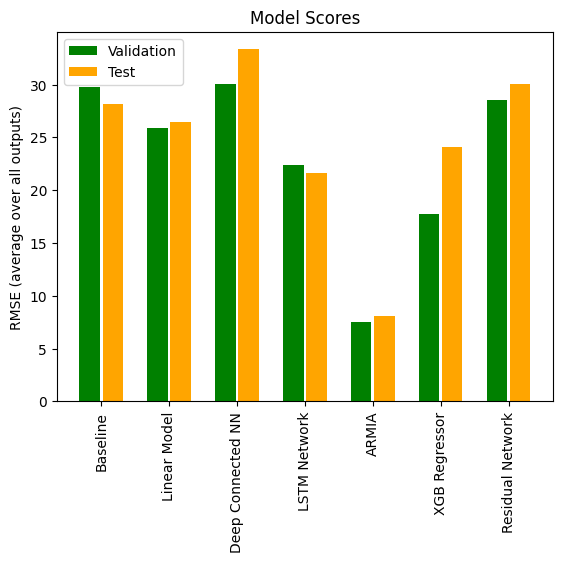

In [25]:
width = 0.3
model_names = validation_scores.keys()
x = np.arange(len(model_names))
validation = validation_scores.values()
tests = test_scores.values()
fig, ax = plt.subplots(1, 1)
ax.set_title("Model Scores")
ax.bar(x - 0.17, validation, width, label="Validation", color='green')
ax.bar(x + 0.17, tests, width, label="Test", color='orange')
ax.set_xticks(ticks=x, labels=model_names, rotation=90)
ax.set_ylabel("RMSE (average over all outputs)")
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_minor_formatter(NullFormatter())
_ = ax.legend()

## Conclusions

We found that the ARIMA model provided by far the best performance in validation and test. This is perhaps due to the nature of the ARIMA model and its suitability to auto-regressive time series data. Unlike ARIMA, all other models lack this auto-regressive feature. With that said, the ARIMA model is computationally expensive and is significantly slower than all other models shown in this notebook.  

To improve on what was done here, one could begin with more and better data. Our data in this project was limited to weather, DA_price, RT_price and natural gas prices. One could incorporate more data into teh 